In [1]:
import pandas as pd
import re
import bz2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock

In [2]:
bills = pd.read_csv('../data_cleaning/bills.csv').drop(columns='Unnamed: 0')

### Vectorization and IDF scaling

In [5]:
tfidf = TfidfVectorizer(token_pattern=r'[a-z]+', stop_words='english', min_df=0.01, max_df=0.99).fit(bills['long_title'])
X_idf  = tfidf.transform(bills['long_title']).toarray()
X_feat_names = tfidf.get_feature_names()

### Dimensionality Reduction by SVD

In [6]:
def truncated_svd(X):
    '''Reduce dimensionality of TFIDF Matrix.'''
    q, s, p = np.linalg.svd(X)
    return q, np.diag(s), p.T, s**2/np.linalg.norm(s**2, 1)

q, s, p, nssd = truncated_svd(X_idf)

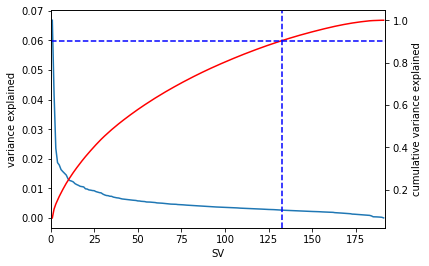

In [7]:
fig, ax = plt.subplots()

ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
ax.axhline(0.9, ls='--', color='b')
ax.axvline(133, ls='--', color='b')
ax.set_ylabel('cumulative variance explained');

In [10]:
X_trunc = X_idf.dot(p[:, :133])

### Clustering

**Agglomerative Clustering**

In [12]:
y_pred_list_agg_ward = []
for k in range(2, 6):
    agc = AgglomerativeClustering(n_clusters=k, 
                                  linkage='ward').fit_predict(X_trunc)
    y_pred_list_agg_ward.append(agc)

In [13]:
## Plot the clusters

X_trunc2 = (TruncatedSVD(n_components=2)
                    .fit_transform(X_idf))

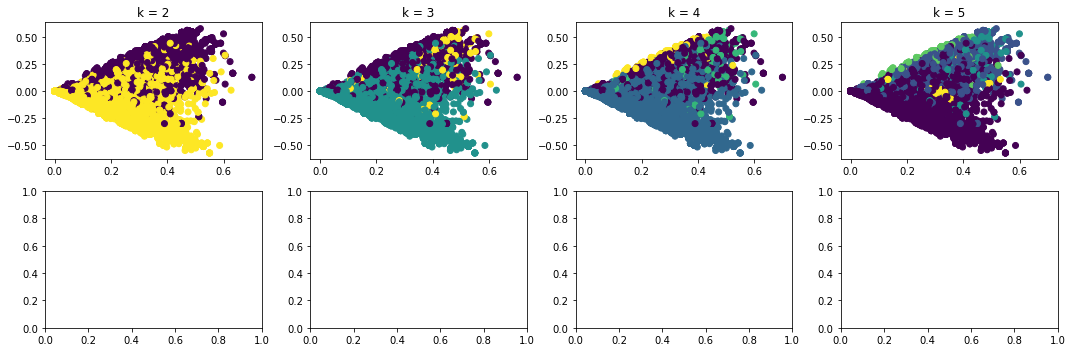

In [14]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(2, 6):
    ax_list[i-2].scatter(X_trunc2[:, 0], X_trunc2[:, 1], c=y_pred_list_agg_ward[i-2])
    ax_list[i-2].set_title(f'k = {i}')
    
plt.tight_layout()

### AUC-PR

In [19]:
def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query
    
    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects
    objects : ndarray
        vector-represented objects in the database; rows correspond to 
        objects, columns correspond to features
    k : int
        number of most similar objects to return
    dist : function
        accepts two ndarrays as parameters then returns their distance
    
    Returns
    -------
    ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort([dist(query, o) for o in objects])[:k]

In [20]:
def pr_curve(query, objects, dist, actual, all_labels):
    all_labels = np.array(all_labels)
    results = nearest_k(query, objects, len(all_labels), dist)
    rs = (all_labels[results] == actual).cumsum()
    N = (all_labels == actual).sum()
    precision = rs / np.arange(1, len(rs)+1)
    recalls = rs / N
#     print(rs)
#     print(N)
#     print(recalls)
    recalls = [0] + recalls.tolist()
    precision = [1] + precision.tolist()
#     print(recalls)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.step(recalls, precision, where='post')
    ax.fill_between(recalls, precision, step='post', alpha=0.6)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    
    return ax

In [21]:
def auc_pr(query, objects, dist, actual, all_labels):
    ax = pr_curve(query, objects, dist, actual, all_labels)
    
    x = ax.lines[0].get_data()[0]
    y = ax.lines[0].get_data()[1]
    
    return np.trapz(y, x)

0.7734322680221248

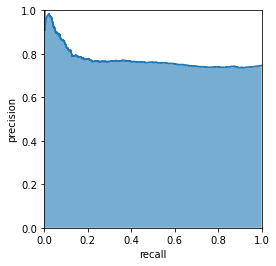

In [25]:
## choose arbitrary no. of clusters 
k = 3

auc_pr(X_trunc[0, :], X_trunc, euclidean, y_pred_list_agg_ward[k-2][0], y_pred_list_agg_ward[k-2])